# This notebook plots the number density of Tb-defined MCS on a map
## It uses MCS track statistics file and counts each unique MCS located on a 1x1 degree grid once

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
# run_name = 'mpi'
# run_name = 'scream'
# run_name = 'noaa'
# run_name = 'nicam'
# run_name = 'nasa'
run_name = 'uk'

# Dictionary for official model names
model_name = {
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

# Turn on xlabel for UK model
if run_name == 'uk':
    xlabel_m = True
else:
    xlabel_m = False

# test = ''
# test = '_pf0duration'
test = '_ccs2h10k_pf0duration'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}/obs/stats{test}/'
moddir = f'{rootdir}{run_name}/stats{test}/'
obsfile = f'{obsdir}mcs_tracks_20200120.0000_20200301.0000.nc'
modfile = f'{moddir}mcs_tracks_20200120.0000_20200301.0000.nc'

topfile = '/global/project/projectdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)
print(obsfile)
print(modfile)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_ccs2h10k_pf0duration/
/global/cfs/cdirs/m1867/zfeng/dyamond-winter//obs/stats_ccs2h10k_pf0duration/mcs_tracks_20200120.0000_20200301.0000.nc
/global/cfs/cdirs/m1867/zfeng/dyamond-winter/uk/stats_ccs2h10k_pf0duration/mcs_tracks_20200120.0000_20200301.0000.nc


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [3]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)>
array([[-0.19099763, -0.2824136 ,  0.17526372, ...,  1.1824327 ,
         0.35849398,  0.26687884],
       [-0.19099763,  0.54152507,  0.35849398, ...,  2.2812166 ,
         1.3656629 ,  0.9994015 ],
       [-1.656043  , -0.9235203 ,  0.08384776, ...,  7.134229  ,
         0.9077864 , -0.55725896],
       ...,
       [ 0.35849398,  0.17526372,  0.17526372, ..., -0.46564385,
        -0.3740287 ,  0.17526372],
       [-0.3740287 , -0.0993825 ,  0.08384776, ...,  0.35849398,
         0.17526372,  0.17526372],
       [-0.00776737,  0.26687884, -0.00776737, ...,  0.08384776,
         0.17526372,  0.54152507]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 1979-01-01

In [5]:
# Read OBS data
dsobs = xr.open_dataset(obsfile)
dsobs

<xarray.Dataset>
Dimensions:                  (tracks: 21468, times: 400, mergers: 50)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 21464 21465 21466 21467
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
Data variables: (12/26)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    mcs_status               (tracks, times) float32 ...
    ccs_area                 (tracks, times) float32 ...
    merge_cloudnumber        (tracks, times, mergers) float64 ...
    split_cloudnumber        (tracks, times, mergers) float64 ...
    merge_ccs_area           (tracks, times, mergers) float32 ...
    split_ccs_area           (tracks, times, mergers) float32 ...
Attributes:
    Title:                 Statistics of each MCS track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Apr 26 09:23:54 2022
    startdate:             20200120.0000
    enddate:               20200301.0000
    timegap_hour:          3.1
    time_resolution_hour:  1.0
    pixel_radius_km:       10.0
    MCS_duration_hr:       2
    MCS_area_km^2:         10000

In [6]:
# Read MODEL data
dsmod = xr.open_dataset(modfile)
dsmod

<xarray.Dataset>
Dimensions:                  (tracks: 15235, times: 400, mergers: 50)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 15231 15232 15233 15234
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
Data variables: (12/26)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    mcs_status               (tracks, times) float32 ...
    ccs_area                 (tracks, times) float32 ...
    merge_cloudnumber        (tracks, times, mergers) float64 ...
    split_cloudnumber        (tracks, times, mergers) float64 ...
    merge_ccs_area           (tracks, times, mergers) float32 ...
    split_ccs_area           (tracks, times, mergers) float32 ...
Attributes:
    Title:                 Statistics of each MCS track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Fri Sep 23 23:35:48 2022
    startdate:             20200120.0000
    enddate:               20200301.0000
    timegap_hour:          3.1
    time_resolution_hour:  1.0
    pixel_radius_km:       10.0
    MCS_duration_hr:       2
    MCS_area_km^2:         10000

In [7]:
def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

In [8]:
ranges = [[-60,60], [0,360]]
xbins = np.arange(0, 360.1, 1)
ybins = np.arange(-60., 60.1, 1)

In [9]:
# Get track initial time valuees
base_time_obs = dsobs.base_time.load()
starttime_obs = base_time_obs.isel(times=0)
syear_obs = starttime_obs.dt.year
smonth_obs = starttime_obs.dt.month
nyears_obs = len(np.unique(syear_obs))
nmcs_obs = len(starttime_obs.where(smonth_obs == 2, drop=True))
print(f'Number of MCS (OBS): {nmcs_obs}')

Number of MCS (OBS): 15272


In [10]:
# smonth_obs = starttime_obs.dt.month
# # dsobs.sel(smonth_obs=2)
# nmcs_obs = len(starttime_obs.where(smonth_obs == 2, drop=True))
# print(f'Number of MCS (OBS): {nmcs_obs}')

In [11]:
# Get track initial time valuees
base_time_mod = dsmod.base_time.load()
starttime_mod = base_time_mod.isel(times=0)
syear_mod = starttime_mod.dt.year
smonth_mod = starttime_mod.dt.month
nyears_mod = len(np.unique(syear_mod))
nmcs_mod = len(starttime_mod.where(smonth_mod == 2, drop=True))
print(f'Number of MCS (MODEL): {nmcs_mod}')

Number of MCS (MODEL): 10514


In [12]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_obs = dsobs.meanlat.where(smonth_obs == 2, drop=True).load().round().values
rlon_obs = dsobs.meanlon.where(smonth_obs == 2, drop=True).load().round().values
rlat_mod = dsmod.meanlat.where(smonth_mod == 2, drop=True).load().round().values
rlon_mod = dsmod.meanlon.where(smonth_mod == 2, drop=True).load().round().values

lat0_obs = dsobs.meanlat.isel(times=0).where(smonth_obs == 2, drop=True)
lon0_obs = dsobs.meanlon.isel(times=0).where(smonth_obs == 2, drop=True)
lat0_mod = dsmod.meanlat.isel(times=0).where(smonth_mod == 2, drop=True)
lon0_mod = dsmod.meanlon.isel(times=0).where(smonth_mod == 2, drop=True)

In [13]:
# Total MCS count
mcs_ircount_obs = count_unique_mcs(rlat_obs, rlon_obs, xbins, ybins)
mcs_ircount_mod = count_unique_mcs(rlat_mod, rlon_mod, xbins, ybins)

In [14]:
# Divide by the number of years to get annual mean
mcs_irnumber_obs = mcs_ircount_obs / nyears_obs
mcs_irnumber_mod = mcs_ircount_mod / nyears_mod

In [15]:
xbins5 = np.arange(0,361,5)
ybins5 = np.arange(-60,61,5)
ranges = [[min(ybins5), max(ybins5)], [min(xbins5), max(xbins5)]]

In [16]:
xbins5 = np.arange(0,361,5)
ybins5 = np.arange(-60,61,5)
ranges5 = [[min(ybins5), max(ybins5)], [min(xbins5), max(xbins5)]]
mcs_initcount_obs, yedges, xedges = np.histogram2d(lat0_obs, lon0_obs, bins=[ybins5, xbins5], range=ranges5)
mcs_initcount_mod, yedges, xedges = np.histogram2d(lat0_mod, lon0_mod, bins=[ybins5, xbins5], range=ranges5)

In [17]:
xbins5.shape, ybins5.shape, mcs_initcount_obs.shape

((73,), (25,), (24, 72))

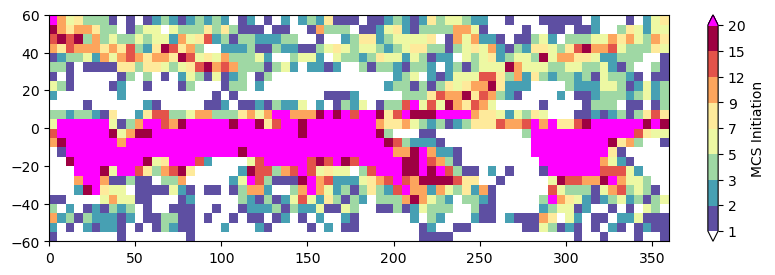

In [18]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15,20]
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins5, ybins5, mcs_initcount_obs, shading='flat', norm=norm, cmap=cmap)
plt.colorbar(label='MCS Initiation', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

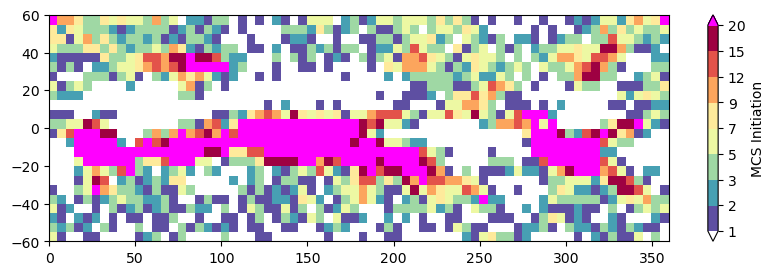

In [19]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15,20]
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins5, ybins5, mcs_initcount_mod, shading='flat', norm=norm, cmap=cmap)
plt.colorbar(label='MCS Initiation', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

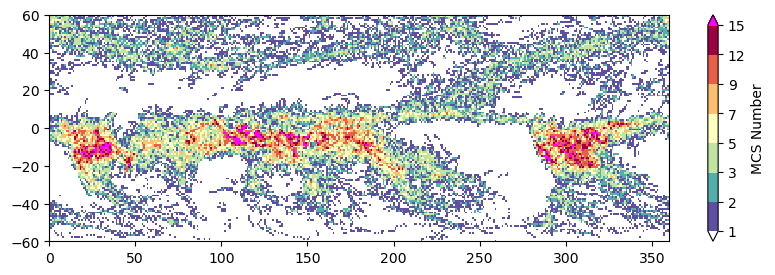

In [20]:
fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_obs, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

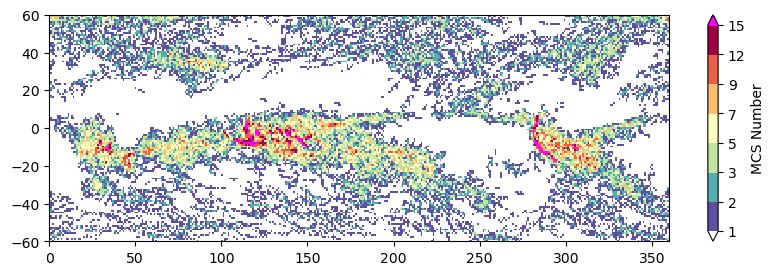

In [21]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15]
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_mod, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

<ipython-input-22-7243786c28f5>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins, latbins, diff, norm=norm, cmap=cmap)


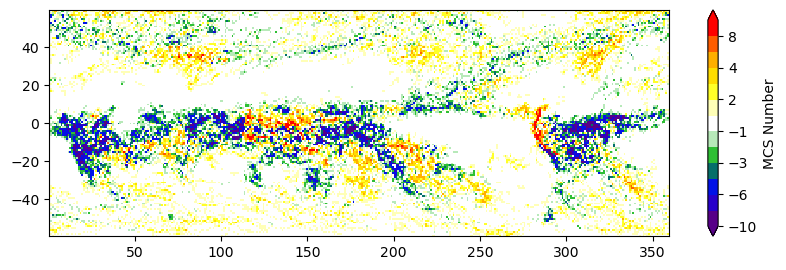

In [22]:
diff = mcs_irnumber_mod - mcs_irnumber_obs
diffs = gaussian_filter(diff, 1.0)

# Calculate lat/lon bin center value
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.

fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [-12,-8,-6,-4,-3,-2,-1,1,2,3,4,6,8,12]
levels = [-10,-8,-6,-4,-3,-2,-1,1,2,3,4,6,8,10]
cbticks = levels
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lonbins, latbins, diff, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')

# lev_p = [1,4,8]
# lev_n = [-8,-4,-1]
# plt.contour(lonbins, latbins, diffs, levels=lev_n, colors='r', linestyles='-')
# plt.contour(lonbins, latbins, diffs, levels=lev_p, colors='b', linestyles='-')

<ipython-input-23-f66f71a3d5ff>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins5, latbins5, diff5, norm=norm, cmap=cmap)


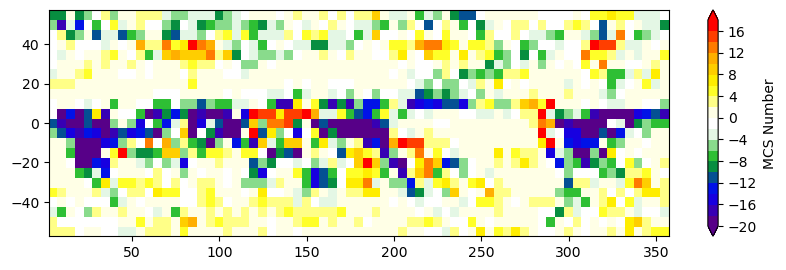

In [23]:
# Accumulate MCS number to a coarser 5 deg grid
mcs_irnumber_obs5 = np.zeros((len(ybins5)-1, len(xbins5)-1), dtype=float)
mcs_irnumber_mod5 = np.zeros((len(ybins5)-1, len(xbins5)-1), dtype=float)
for ix in range(len(xbins5)-1):
    for iy in range(len(ybins5)-1):
        idx = np.where((xbins >= xbins5[ix]) & (xbins < xbins5[ix+1]))
        idy = np.where((ybins >= ybins5[iy]) & (ybins < ybins5[iy+1]))
        mcs_irnumber_obs5[iy,ix] = np.nansum(mcs_irnumber_obs[idy,idx])
        mcs_irnumber_mod5[iy,ix] = np.nansum(mcs_irnumber_mod[idy,idx])

# Calculate lat/lon bin center value
lonbins5 = xbins5[:-1] + np.diff(xbins5)/2.
latbins5 = ybins5[:-1] + np.diff(ybins5)/2.

diff5 = mcs_irnumber_mod5 - mcs_irnumber_obs5
diffs5 = gaussian_filter(diff5, 0.5)

fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(-20,20.,2)
cbticks = levels
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lonbins5, latbins5, diff5, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')

# lev_p = [5,8,15]
# lev_n = [-15,-8,-5]
# plt.contour(lonbins5, latbins5, diffs5, levels=lev_n, colors='r', linestyles='-')
# plt.contour(lonbins5, latbins5, diffs5, levels=lev_p, colors='b', linestyles='-')

In [24]:
figdir

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_ccs2h10k_pf0duration/'

In [25]:
def plot_map_single(dataarray, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                    oob_colors=None, mask=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, clev_colors=None,
                    xlabel=True, ylabel=True, colorbar=True, figsize=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=figsize, dpi=100)
    ax = plt.subplot(111, projection=proj)
    ax.set_extent(map_extend, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    # ax.set_title(title, loc='left')
    ax.set_aspect('auto', adjustable=None) 
    flabel = ax.text(0.02, 0.05, title, transform=ax.transAxes, fontsize=14)
    flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))

    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    if xlabel is True:
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(lonv, crs=ccrs.PlateCarree())
    if ylabel is True:
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)

    # Plot data
    cmap = copy.copy(mpl.cm.get_cmap(cmap))
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    Zm1 = dataarray[0]
    Zm1s = gaussian_filter(Zm1, 0.5)
    if (contourf == False):
        pcm1 = ax.pcolormesh(lonarr[0], latarr[0], Zm1, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
    else:
        pcm1 = ax.contourf(lonarr[0], latarr[0], Zm1s, levels=levels, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)
        
    # Set out of bound colors
    if oob_colors is not None:
        pcm1.cmap.set_over(oob_colors['over'])
        pcm1.cmap.set_under(oob_colors['under'])
        pcm1.set_clim(min(levels), max(levels))
    # Plot colorbar
    if colorbar == True:
        if (contourf == False):
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks, extend='both')
        else:
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks)

    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
            ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
            text_color = clev_colors['pos'] if (boxtext[ii] >=0) else clev_colors['neg']
            ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                    fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

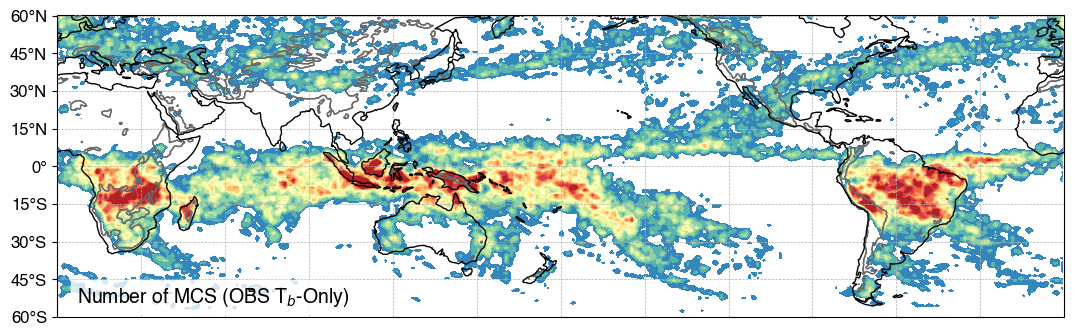

In [26]:
# Calculate lat/lon bin center value
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.

title = f'Number of MCS (OBS T$_b$-Only)'
dataarr = [mcs_irnumber_obs]
lonarr = [lonbins, lonbins]
latarr = [latbins, latbins]
levels = np.arange(1,12.1,1)
cbticks = levels
cblabel = 'Number of MCS'
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.1, 0.9)
figname = f'{figdir}globalmap_tb_mcs_number_map_1panel_smooth_obs.png'
oob_colors = {'under':'white', 'over':'firebrick'}
fig = plot_map_single(dataarr, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=True, xlabel=False, colorbar=False, figsize=[13,4])

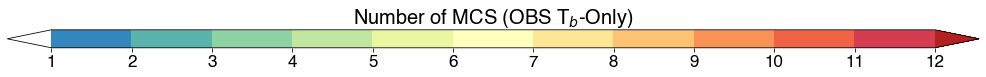

In [27]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.1, 0.9)
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
levels = np.arange(1,12.1,1)
boundaries = np.concatenate(([0], levels, [10]))
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'Number of MCS (OBS T$_b$-Only)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}globalmap_tb_mcs_number_obs_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

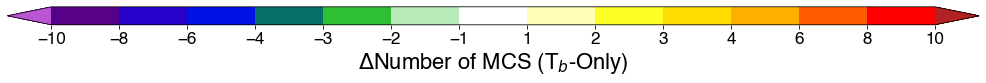

In [28]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
levels = [-10,-8,-6,-4,-3,-2,-1,1,2,3,4,6,8,10]
# levels = [-12,-8,-6,-4,-3,-2,2,3,4,6,8,12]
cbticks = levels
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
oob_colors = {'under':'mediumorchid', 'over':'firebrick'}
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
# boundaries = np.concatenate(([0], levels, [10]))
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = '$\Delta$Number of MCS (T$_b$-Only)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.set_label(label=cblabel, size=22)
figname = f'{figdir}globalmap_tb_mcs_number_diff_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [29]:
figdir

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_ccs2h10k_pf0duration/'

In [30]:
box_mc = [95,150,-20,5]
box_itcz = [151,250,0,12]
box_spcz = [151,210,-30,-1]
box_io = [50,94,-15,5]
box_afc = [10,40,-20,5]
box_amz = [-75%360,-40%360,-20,0]
box_ao = [-40%360,-10%360,-8,8]
box_amz180 = [-75,-40,-20,0]
box_ao180 = [-40,-10,-8,8]
boxes = {'maritime_continent':box_mc, 
         'itcz':box_itcz, 
         'spcz':box_spcz, 
         'indian_ocean':box_io, 
         'africa':box_afc, 
         'amazon':box_amz, 
         'atlantic_ocean':box_ao}
# For plotting only
boxes4plot = copy.deepcopy(boxes)
boxes4plot['amazon'] = box_amz180
boxes4plot['atlantic_ocean'] = box_ao180
boxes['amazon'][0]
# box_amz

285

In [31]:
# Calculate regional mean difference
diff_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
# for ii in range(len(boxes)):
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lonbins >= boxes[name][0]) & (lonbins <= boxes[name][1]))[0]
    yid = np.where((latbins >= boxes[name][2]) & (latbins <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    val_mod = mcs_irnumber_mod[min(yid):max(yid), min(xid):max(xid)]
    val_obs = mcs_irnumber_obs[min(yid):max(yid), min(xid):max(xid)]
    diff_reg[ii] = 100 * (np.nansum(val_mod) - np.nansum(val_obs)) / np.nansum(val_obs)
    # print(f'{diff_reg:.00f}%')
# print(diff_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val = dict(zip(boxes.keys(), diff_reg))
# print(text_loc)
print(text_val)

{'maritime_continent': -13.418098201000946, 'itcz': -45.5339153794493, 'spcz': -31.80239898989899, 'indian_ocean': -38.584779706275036, 'africa': -51.640340218712026, 'amazon': -33.92826497339969, 'atlantic_ocean': -63.70455856895557}


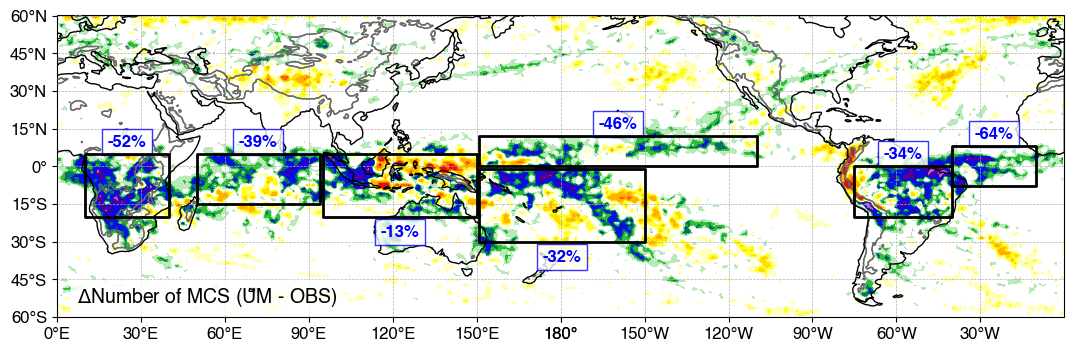

In [32]:
# Calculate lat/lon bin center value
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.

title = f'$\Delta$Number of MCS ({model_name[run_name]} - OBS)'
diff = mcs_irnumber_mod - mcs_irnumber_obs
# diff[np.abs(diff) < 1] = 0
# diffs = gaussian_filter(diff, 1.0)
dataarr = [diff]
lonarr = [lonbins, lonbins]
latarr = [latbins, latbins]
levels = [-10,-8,-6,-4,-3,-2,-1,1,2,3,4,6,8,10]
# levels = [-12,-8,-6,-4,-3,-2,2,3,4,6,8,12]
clev_colors = {'pos':'orangered', 'neg':'blue'}
cbticks = levels
cblabel = '$\Delta$Number of MCS'
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
figname = f'{figdir}globalmap_tb_mcs_number_map_diff_1panel_smooth_regions_{run_name}.png'
oob_colors = {'under':'mediumorchid', 'over':'firebrick'}
fig = plot_map_single(dataarr, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=True, boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val, clev_colors=clev_colors,
                      xlabel=xlabel_m, colorbar=False, figsize=[13,4])

In [33]:
figname

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_ccs2h10k_pf0duration/globalmap_tb_mcs_number_map_diff_1panel_smooth_regions_uk.png'